4. Solar power consumption has been recorded by city councils at regular intervals. The reason behind doing so is to understand how businesses are using solar power so that they can cut down on nonrenewable sources of energy and shift towards renewable energy. Based on the data, build a forecasting model and provide insights on it. 

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# importing dataset
df = pd.read_csv('C:/Users/vaibh/Desktop/360 Digitmg/Time Series/Assignment/solarpower_cumuldaybyday2.csv')
df.head()

,date,cum_power
0,26/10/2011,0.1
1,27/10/2011,10.2
2,28/10/2011,20.2
3,29/10/2011,29.6
4,30/10/2011,34.2


In [3]:
df.shape

(2558, 2)

In [4]:
# Descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cum_power,2558.0,13461.057349,8129.192104,0.1,6665.35,13000.5,20183.75,28120.0


In [5]:
# Datatypes of the feature
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2558 entries, 0 to 2557
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       2558 non-null   object 
 1   cum_power  2558 non-null   float64
dtypes: float64(1), object(1)
memory usage: 40.1+ KB


In [6]:
# checking for null values
df.isnull().sum()

date         0
cum_power    0
dtype: int64

In [7]:
# checking for duplicated values
df.duplicated().sum()

0

In [8]:
# Converting to datetime
df.date = pd.to_datetime(df.date, format='%d/%m/%Y')

We can see the data is on a daily basis . Lets aggregate the data on a montly basis

In [9]:
# Resampling the data on montly basis using sum 
df.set_index('date', inplace=True)
df_new = df.resample('MS').sum()

<Figure size 720x432 with 0 Axes>

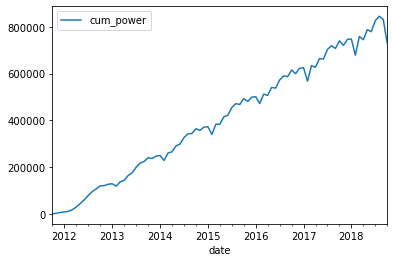

In [10]:
# Line plot 
plt.figure(figsize=(10,6))
df_new.plot()
plt.show()

    We can see an upward trend in the data. This shows that more and more people are opting for renewable solar power day by day. Seeing the trend we can roughly say the consumption will further increase in the next year.

In [11]:
df = df_new.reset_index()

In [12]:
# Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(df.cum_power, autolag='AIC')
dfoutput = pd.Series(dftest, index=['Test Statistic', 'p-value', '#lags Used',\
                                       'Number of Observations Used','Critical Values','icbest'])
dfoutput

Test Statistic                                                         -0.966272
p-value                                                                 0.765366
#lags Used                                                                    11
Number of Observations Used                                                   73
Critical Values                {'1%': -3.5232835753964475, '5%': -2.902030597...
icbest                                                               1597.778096
dtype: object

p-value is greater than 0.05 meaning we accept the null hypothesis. The variable is non-stationary

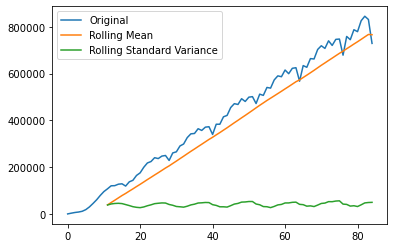

In [13]:
# Rolling Statistics

rolmean = df.cum_power.rolling(window=12).mean()
rolvar = df.cum_power.rolling(window=12).std()

plt.plot(df.cum_power, label='Original')
plt.plot(rolmean, label='Rolling Mean')
plt.plot(rolvar, label='Rolling Standard Variance')
plt.legend(loc='best')
plt.show()

    We can see that the mean is not constant 

In [14]:
df.shape

(85, 2)

In [15]:
# Data Partition
Train = df.head(49)
Test = df.tail(36)

In [16]:
# Mean absolute Percentge Error
MAPE = np.mean(np.abs((rolmean.tail(36) - Test.cum_power)/Test.cum_power)*100)
MAPE

8.659404839291959

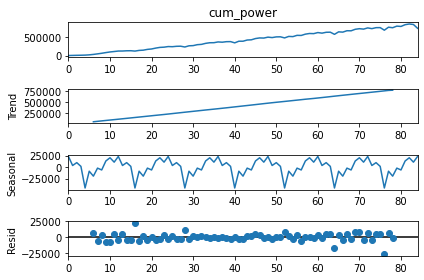

In [17]:
# Decomposing the data to see trend, seasonality using additive model
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_ts_add = seasonal_decompose(df.cum_power, model = "additive", period = 12)

ds_trend = (decompose_ts_add.trend)
ds_seasonal = (decompose_ts_add.seasonal)
ds_resid = (decompose_ts_add.resid)
ds_obser = (decompose_ts_add.observed)

decompose_ts_add.plot()
plt.show()

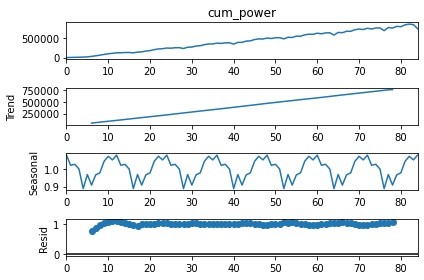

In [18]:
# Decomposing the data to see trend, seasonality using multiplicative model
decompose_ts_mul = seasonal_decompose(df.cum_power, model = "multiplicative", period = 12)
decompose_ts_mul.plot()
plt.show()

E:\ANACONDA\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


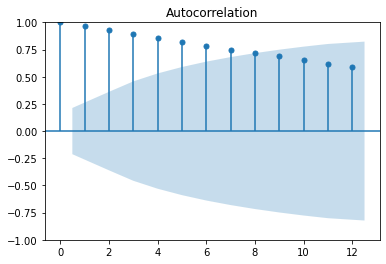

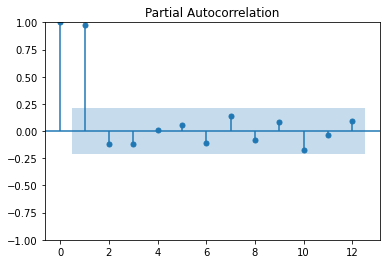

In [19]:
# ACF and PACF plot on Original data sets 

import statsmodels.graphics.tsaplots as tsa_plots

tsa_plots.plot_acf(df.cum_power, lags = 12)
tsa_plots.plot_pacf(df.cum_power, lags = 12)
plt.show()

In [20]:
# Simple Exponential Method
from statsmodels.tsa.holtwinters import SimpleExpSmoothing 

ses_model = SimpleExpSmoothing(Train.cum_power).fit()
pred_ses = ses_model.predict(start = Test.index[0], end = Test.index[-1])
MAPE_ses = np.mean(np.abs((pred_ses - Test.cum_power)/Test.cum_power)*100)
MAPE_ses 

E:\ANACONDA\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


22.778417159903093

In [21]:
# Holt Method
from statsmodels.tsa.holtwinters import Holt

holt_model = Holt(Train.cum_power).fit()
pred_holt = holt_model.predict(start = Test.index[0], end = Test.index[-1])
MAPE_holt = np.mean(np.abs((pred_holt - Test.cum_power) / Test.cum_power)*100)
MAPE_holt 

E:\ANACONDA\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


9.218174382508785

In [22]:
# Holts winter exponential smoothing with additive seasonality and additive trend
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

hwe_model_add_add = ExponentialSmoothing(Train.cum_power, seasonal = "add", trend = "add", seasonal_periods = 12).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0], end = Test.index[-1])
MAPE_hwe_add_add = np.mean(np.abs((pred_hwe_add_add - Test.cum_power) / Test.cum_power)*100)
MAPE_hwe_add_add

E:\ANACONDA\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


1.8948228553432966

In [23]:
# Holts winter exponential smoothing with multiplicative seasonality and additive trend

hwe_model_mul_add = ExponentialSmoothing(Train.cum_power, seasonal = "mul", trend = "add", seasonal_periods = 12).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0], end = Test.index[-1])
MAPE_hwe_mul_add = np.mean(np.abs((pred_hwe_mul_add - Test.cum_power) / Test.cum_power)*100)
MAPE_hwe_mul_add

E:\ANACONDA\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


5.83300167655978

In [24]:
# Final Model on 100% Data
hwe_fmodel_add_add = ExponentialSmoothing(df.cum_power, seasonal = "add", trend = "add", seasonal_periods = 12).fit()

E:\ANACONDA\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [25]:
df.tail()

,date,cum_power
80,2018-06-01,778779.0
81,2018-07-01,825390.0
82,2018-08-01,844605.0
83,2018-09-01,830763.0
84,2018-10-01,728630.0


In [26]:
# Predicting for next 1 year

Pred_Table = pd.DataFrame(data= pd.date_range(start='2018-11-01', periods=36, freq='MS') , index=range(85,121), columns=['date'])
Pred_Table

,date
85,2018-11-01
86,2018-12-01
87,2019-01-01
88,2019-02-01
89,2019-03-01
90,2019-04-01
91,2019-05-01
92,2019-06-01
93,2019-07-01
94,2019-08-01


In [27]:
Pred_Table['cum_power'] = hwe_fmodel_add_add.predict(start = Pred_Table.index[0], end = Pred_Table.index[-1])
Pred_Table.cum_power

85     7.843956e+05
86     8.023925e+05
87     8.031513e+05
88     7.650722e+05
89     8.196134e+05
90     8.139638e+05
91     8.459923e+05
92     8.459402e+05
93     8.811391e+05
94     8.958042e+05
95     8.904391e+05
96     9.132596e+05
97     9.010302e+05
98     9.190271e+05
99     9.197858e+05
100    8.817068e+05
101    9.362480e+05
102    9.305984e+05
103    9.626268e+05
104    9.625747e+05
105    9.977736e+05
106    1.012439e+06
107    1.007074e+06
108    1.029894e+06
109    1.017665e+06
110    1.035662e+06
111    1.036420e+06
112    9.983413e+05
113    1.052883e+06
114    1.047233e+06
115    1.079261e+06
116    1.079209e+06
117    1.114408e+06
118    1.129073e+06
119    1.123708e+06
120    1.146529e+06
Name: cum_power, dtype: float64

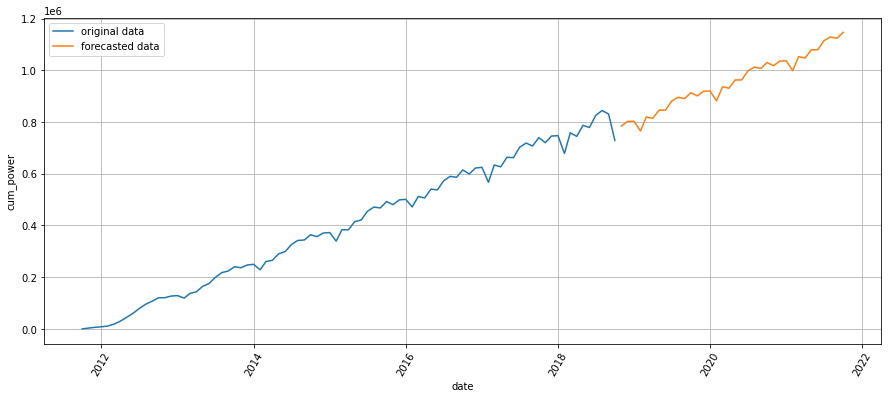

In [28]:
# Plotting forecasted and original data
plt.figure(figsize=(15,6))
sns.lineplot(y = df.cum_power, x = df.date, label = 'original data')
sns.lineplot(y = Pred_Table.cum_power, x = Pred_Table.date, label = 'forecasted data')
plt.xticks(rotation = 60)
plt.legend(loc='best')
plt.grid('on')
plt.show()

# ARIMA MODEL

In [29]:
# Lets use ARIMA model

import pmdarima as pm                # Using pmdarima for auto arima to find optimal orders

ar_model = pm.auto_arima(Train.cum_power, start_p=0, start_q=0,
                      max_p=12, max_q=12,                
                      m=1,                               
                      d=None,                            
                      seasonal=True,                    
                      start_P=0, trace=True,
                      error_action='warn', stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1054.140, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1051.749, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1054.909, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1073.678, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1051.045, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1051.680, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1052.767, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1053.485, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1051.019, Time=0.08 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1044.351, Time=0.32 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1049.485, Time=0.04 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1040.813, Time=0.33 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1050.403, Time=0.05 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=1024.407, Time=0.42 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept

.

In [30]:
# ARIMA with AR=9, I = 1, MA = 3
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(Train.cum_power, order = (9,1,3))
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:              cum_power   No. Observations:                   49
Model:                 ARIMA(9, 1, 3)   Log Likelihood                -508.834
Date:                Sun, 07 Aug 2022   AIC                           1043.669
Time:                        01:16:32   BIC                           1067.995
Sample:                             0   HQIC                          1052.862
                                 - 49                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0010      0.604      0.002      0.999      -1.183       1.185
ar.L2          0.1078      0.586      0.184      0.854      -1.040       1.256
ar.L3          0.7835      0.462      1.694      0.0

In [31]:
# Predicting for test data

test_pred = res.predict(start = Test.index[0], end = Test.index[-1])

# Checking for MAPE
MAPE_arima = np.mean(np.abs((test_pred - Test.cum_power) / Test.cum_power)*100)
MAPE_arima

2.4658198447101958

In [32]:
# Fitting on 100% data

f_model = ARIMA(df.cum_power, order = (9,1,3))
f_res = f_model.fit()

Pred_Table['ARIMA_cum_power'] = f_res.predict(start = Pred_Table.index[0], end = Pred_Table.index[-1])
Pred_Table.ARIMA_cum_power

E:\ANACONDA\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
E:\ANACONDA\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


85     7.571673e+05
86     7.416094e+05
87     7.543765e+05
88     7.635722e+05
89     7.908398e+05
90     8.709384e+05
91     8.803529e+05
92     8.660815e+05
93     8.601066e+05
94     8.766681e+05
95     8.500675e+05
96     8.112982e+05
97     8.227679e+05
98     8.589721e+05
99     8.829005e+05
100    8.811812e+05
101    9.083718e+05
102    9.482031e+05
103    9.470360e+05
104    9.162996e+05
105    9.094585e+05
106    9.283438e+05
107    9.236225e+05
108    9.073948e+05
109    9.245860e+05
110    9.676300e+05
111    9.847983e+05
112    9.749443e+05
113    9.843631e+05
114    1.008721e+06
115    1.004936e+06
116    9.785461e+05
117    9.787001e+05
118    1.005434e+06
119    1.014518e+06
120    1.006145e+06
Name: ARIMA_cum_power, dtype: float64

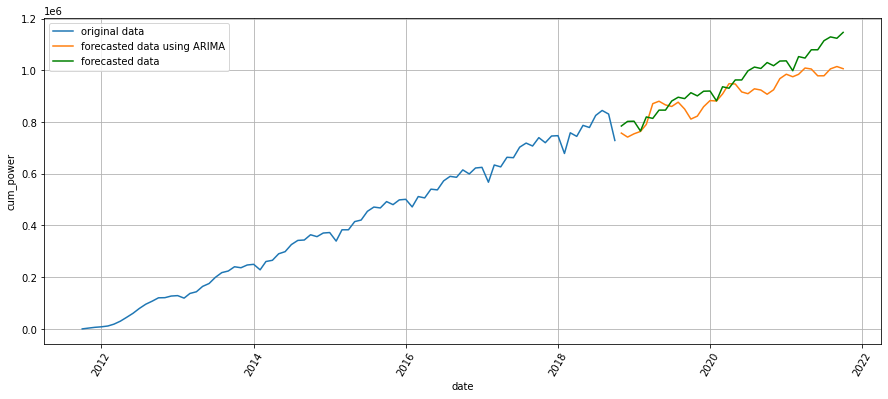

In [33]:
# Plotting forecasted and original data using ARIMA model

plt.figure(figsize=(15,6))
sns.lineplot(y = df.cum_power, x = df.date, label = 'original data')
sns.lineplot(y = Pred_Table.ARIMA_cum_power, x = Pred_Table.date, label = 'forecasted data using ARIMA')
sns.lineplot(y = Pred_Table.cum_power, x = Pred_Table.date, label = 'forecasted data',color = 'g' )
plt.xticks(rotation = 60)
plt.legend(loc='best')
plt.grid('on')
plt.show()

Using ARIMA model we get more residual error as compared to Exponential Smoothing with additive seasonality.